# Computer Lab: nonnegative matrix factorization

This report of SD-TSIA211 was made by <font color="red"><b>Gaspard Robert</b></font> and <font color="red"><b>Théo Rouvet</b></font>.

The beginning consists in appropriate library importations, as well as useful processing functions definition.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.sparse
import scipy.sparse.linalg
from time import time

In [2]:
def build_matrix_from_faces(folder='orl_faces', minidata=False):
    # load images
    # 400 images of size (112, 92)
    M = []
    if minidata is True:
        nb_subjects = 1
    else:
        nb_subjects = 40
    for subject in range(1, nb_subjects + 1
                        ):
        for image in range(1, 11):
            face = plt.imread(folder + '/s' + str(subject)
                              + '/' + str(image) + '.pgm')
            M.append(face.ravel())

    return np.array(M, dtype=float)

def vectorize(W, H):
    return np.concatenate((W.ravel(), H.ravel()))

def unvectorize_M(W_H, M):
    # number of elements in W_H is (n+p)*k where M is of size n x m
    # W has the nk first elements
    # H has the kp last elements
    n, p = M.shape
    k = W_H.shape[0] // (n + p)
    W = W_H[:n * k].reshape((n, k))
    H = W_H[n * k:].reshape((k, p))
    return W, H

Download the database at https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html.
Uncompress the file.

In [3]:
# Small data to test the algorithm
M = build_matrix_from_faces(folder="./orl_faces", minidata=False)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 38

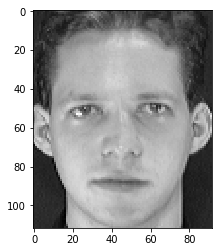

In [4]:
# To see the first face:
plt.imshow(M[0].reshape((112, 92)), cmap='gray'); plt.show()

## Part 1 - Database

In [5]:
# Full data
M = build_matrix_from_faces(folder='orl_faces', minidata=False)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 38
n = M.shape[0]
p = M.shape[1]
print(M.shape)

(400, 10304)


The database is composed of **400 images of size $(112,92)$**, as 112*92 = 10304.

## Part 2 - Presentation of the model

### Question 2.1

We note $f(x,y) = (\alpha -xy)^2$ where $\alpha$ is a given nonnegative real number. $f$ is of $C^2$-class (i.e. it is twice continuously differentiable) on $(\mathbb{R^+})^2$ as a polynomial function of $x$ and $y$. 

The Hessian matrix of $f$ is: $$\forall x,y \in \mathbb{R^+}, \nabla^2f(x,y) = \left( {\begin{array}{cc}
     2y^2 & -2\alpha + 4xy  \\
     -2\alpha + 4xy & 2x^2 \\
     \end{array} } \right)$$

Therefore, its determinant is: $$\forall x,y \in \mathbb{R^+}, \text{D}(x,y) = \text{det}(\nabla^2f(x,y)) = -12x^2y^2 + 16\alpha xy -4\alpha^2 $$

We know from MDI210 that **a function twice continously differentiable is convex if and only if its Hessian Matrix is nonnegative at each point of the set**. 

The determinant of the Hessian matrix being the product of the eigen values of $\nabla^2f$, in order to **prove that $f$ is not convex, it is sufficient to show that $\exists (x_0,y_0) \in (\mathbb{R^+})^2, \text{D}(x_0,y_0) < 0$**.

Let us set a given $y_0 \in \mathbb{R^+}$. It is obvious that $\underset{x \rightarrow +\infty}{\lim} D(x,y_0) = -\infty$, hence $\exists x_0 \in \mathbb{R^+}, \text{D}(x_0,y_0) < 0$, so the determinant of the Hessian Matrix is negative at this point, so **the Hessian matrix is not nonnegative at this point** (its eigen values are of opposite sign, so one of them is negative).

To conclude, **we have shown that $f$ is not a convex function**. This result can be generalised for higher dimension.

### Question 2.2

For the following, we will denote $$f :  (W,H) \mapsto \frac{1}{2np} \sum_{i=1}^n \sum_{l=1}^n \left(M_{i,l} - \sum_{j=1}^k W_{i,j}H_{j,l}\right)^2 = \frac{1}{2np} \|M-WH\|_F^2$$

as being **the objective function**, defined for couples of nonnegatives matrices. Using the canonical rules for norm and scalar product derivations, we obtain the derivatives of order 1 for $f$ : $$\nabla f(W,H) = \left(\frac{\partial f}{\partial W}(W,H), \text{ } \frac{\partial f}{\partial H}(W,H)\right) = \left(\frac{1}{np}(WH-M)H^T, \text{ } \frac{1}{np}W^T(WH-M) \right) $$

We then have computed the components of the gradient vector of the objective function.

## Part 3 - Find $W$ when $H_0$ is fixed

### Question 3.1

In [6]:
W0, S, H0 = scipy.sparse.linalg.svds(M, k)
W0 = np.maximum(0, W0*np.sqrt(S))
H0 = np.maximum(0, (H0.T*np.sqrt(S)).T)

The singular value decompositions (svds) decompose the matrix $M$ as the product of three matrices: $M = W_0SH_0^T$, with $S$ a diagonal matrix containing the singular values of $M$ (which are **nonnegative**). 

We wish to have a decomposition of $M$ as the product of two matrices, so it is natural to "split" the matrix S using the square root: $ S = \sqrt{S} \cdot \sqrt{S} $ where 

$$ \sqrt{S} = \left( {\begin{array}{cccccccc}
     \sqrt{\lambda_1} & 0 & . & . & . & . & . & 0 \\
     0 & \sqrt{\lambda_2} & . & . & . & . & . & . \\
     . & . & . & . & . & . & . & . \\
     . & . & . & . & . & . & . & . \\
     . & . & . & . & \sqrt{\lambda_r} & . & . & .  \\
     . & . & . & . & . & 0 & . & .\\
     . & . & . & . & . & . & . & . \\
     0 & . & . & . & . & . & . & 0 \\
     \end{array} } \right) = diag(\sqrt{\lambda_1}, ..., \sqrt{\lambda_r}, 0, ..., 0)$$ as all the $\sqrt{\lambda_i}$ are nonnegative.
     
     
Having done so, we write $M = A \cdot B$, with:
* $ A = max(0, W_0 \sqrt{S})$ as we wish to keep working with nonnegative matrices 
* $B =max(0, \sqrt{S}H_0^T)$ for the same reason.

The **advantage of this method** is that we might get the proper $M=WH_0$ directly if the computed matrices are nonnegative (and it is rather natural to initialise the algorithm with this). We can imagine starting with random matrices as well, which seems less appropriate at first.

### Question 3.2

We have $g(W)=\frac{1}{2np}\|M-WH_0\|_F^2$

Let's comupte the **gradient** of $g(W)$: $\nabla{g}(W) = -\frac{1}{np}(M-WH_0)H_0^T$

Then, the **Hessian matrix** of g is : $\nabla^2 g(W) = \frac{1}{np}H_0H_0^T$

It is positive semi-definite because $\nabla^2 g(W) = N^TN$ with $N=\frac{1}{\sqrt{np}}H_0^T$
Hence, we deduce that <font color="red"><b> g is convex </b></font>.

### Question 3.3

We write the suggested functions.

In [7]:
def g(W):
    return (1/(2*n*p))*np.linalg.norm(M-np.dot(W,H0), 'fro')**2

def gradg(W):
    return (-1/(n*p))*np.dot((M-np.dot(W,H0)),H0.T)


# reshaped functions for scipy.optimize.check_grad

def g_bis(W_bis):
    return 1/(2*n*p)* np.linalg.norm(M.reshape(-1)-(W_bis.reshape((n,k))@H0).reshape(-1))**2

def grad_g_bis(W_bis):
    return ((M -(W_bis.reshape((n,k)))@H0)@H0.T).reshape(-1)/(-n*p)

We check whether the functions are correct using $W_0$ defined with the svds method, and the reshaped version of our fonctions.

In [8]:
scipy.optimize.check_grad(g_bis, grad_g_bis, W0.reshape(-1))

0.002216352437803484

The precision yielded out is of order of magnitude $10^{-3}$ so it is rightful to assume that the functions are correct as so.

### Question 3.4

We remind that, for all $\gamma>0$, the proximal operator is defined as:

$$\text{prox}_{\gamma l_{\mathbb{R^+}}}(y) = \text{arg}\underset{x \in \mathbb{R}}{\text{ min }} \left( \gamma l_{\mathbb{R^+}}(x) + \frac{1}{2} \|x-y\|^2 \right) = \text{arg}\underset{x \in \mathbb{R^+}}{\text{ min }} \left( \gamma l_{\mathbb{R^+}}(x) + \frac{1}{2} \|x-y\|^2 \right) =\text{arg}\underset{x \in \mathbb{R^+}}{\text{ min }} \frac{1}{2} \|x-y\|^2$$ 

where $l_{\mathbb{R^+}}$ is defined in the lab sheet as being **null on $\mathbb{R^+}$ and being $+\infty$ on $\mathbb{R_-^*}$, hence it is equivalent to consider the $\text{arg min}$ onto $\mathbb{R}$ or onto $\mathbb{R^+}$**, hence the two last equalities.


Hence, we can say that: $$ \begin{align} 
                           \forall y \in \mathbb{R^+}, \text{prox}_{\gamma l_{\mathbb{R^+}}}(y) &= y \text{ (*) }\\ 
                           \forall y < 0, \text{prox}_{\gamma l_{\mathbb{R^+}}}(y) &= 0 \text{ (**) }
                           \end{align}$$
          
          
<u>Justification</u>:


* $\text{ (*) }$: We consider $y \in \mathbb{R^+}$. We have that $ \forall x \in \mathbb{R^+}, \frac{1}{2} \|x-y\|^2 \geqslant 0$. Here, $x$ can be equal to $y$ (since it belongs to $\mathbb{R^+}$), so **the whole function is null at this point and this point only**, hence **minimal for $x=y$**. **So in this case, $\text{prox}_{\gamma l_{\mathbb{R^+}}}(y) = y$**.


* $\text{ (**) }$: $x$ cannot be equal to $y$ in that case. This case is equivalent to **minimising the distance between $y$ and any point of $\mathbb{R^+}$**, i.e. **minimising $\|x-y\|^2$ for all $x \in \mathbb{R^+}$**. **Since $y<0$, the closest point of $\mathbb{R^+}$ is $0$, hence $\text{prox}_{\gamma l_{\mathbb{R^+}}}(y) = 0$**.



**Therefore, we can conclude that for all $\gamma>0$, $\text{prox}_{\gamma l_{\mathbb{R^+}}}$ is actually the projection onto $ \mathbb{R^+} $** (as it is equal to the identity function on $\mathbb{R^+}$ and the null function on $\mathbb{R^*_-}$).

### Question 3.5

We use this result to code a projected gradient descent method with constant step $\gamma$.

In [9]:
def projected_gradient_method(val_g, grad_g, W0, gamma, N):
    
    list_g = [val_g(W0)]
    
    for i in range(N):
        
        # gradient descent
        W0 = W0 - gamma * grad_g(W0)
        
        # projection onto R+
        W0 = W0 * (W0>=0) 
        
        list_g.append(val_g(W0))
        
    return W0, list_g

### Question 3.6

In [10]:
L0 = np.linalg.norm(np.dot(np.transpose(H0),H0), 'fro') # Lispchitz constant
gamma = 1/(L0)
print("gamma = ", gamma)

W0_final, list_g_finale = projected_gradient_method(g, gradg, W0, gamma, 100)
print("The value of g(W0) after 100 iterations is:", list_g_finale[-1])

gamma =  3.455542973172828e-06
The value of g(W0) after 100 iterations is: 867.6202599181838


The value of $g(W_0)$ obtained means that **the distance between $M$ and $W_0 \cdot H_0$ is still quite important after 100 iterations** of this algorithm of proximal gradient descent with constant step. This is mainly due to the value of gamma, which is very small (the order of magnitude is $10^{-6}$), so **the convergence of this algorithm is very slow** (the steps towards a local minimum are too small).

## Part 4 - Algorithmic refinement for the problem with $H_0$ fixed

### Question 4.1

We modify the previous algorithm, **adding a line search to find the appropriate step size at each iteration**. We choose to add a Taylor-based line search, as defined in the lecture notes.

In [11]:
b = L0
a = 0.5

def taylor_line_search(val_g, grad_g, b, W0):
    l = 0
    grad = grad_g(W0)
    while val_g(W0-(b*a**l)*grad) > val_g(W0)+np.trace(np.dot(np.transpose(grad),-(b*a**l)*grad))+1/(2*b*a**l)*np.linalg.norm((b*a**l)*grad, 'fro')**2:
        l+=1
    return (b*a**l)

def projected_gradient_method_refined(val_g, grad_g, W0, N):
    list_g = [val_g(W0)]
    for k in range(N):
        gamma_k = taylor_line_search(val_g, grad_g, b, W0)
        W0 = W0 - gamma_k * grad_g(W0)
        W0 = W0 * (W0>=0)
        list_g.append(val_g(W0))
    return W0, list_g

### Question 4.2

In [14]:
W0_final, list_g_finale = projected_gradient_method_refined(g, gradg, W0, 100)
print("The value of g(W0) after 100 iterations is:", list_g_finale[-1])

The value of g(W0) after 100 iterations is: 483.8995981489996


For the **same number of iterations, this method has sharpy enhanced the convergence speed**, as we obtain almost half the value of the previous distance. This is coherent with the fact that we adapt the step size at each iteration, allowing us to go further that with a constant step of $\gamma = \frac{1}{L_0}$. However, it is **far longer to run** than the previous method due to the fact that we need to calculate the $\gamma_k$ at each iteration with the line search.

## Part 5 - Resolution of the full problem

### Question 5.1

We start by redefining the objective function $f$ and its gradient, as both parameters $W$ and $H$ now may vary.

In [15]:
def g_problem(W, H):
    return (1/(2*n*p))*np.linalg.norm(M-np.dot(W,H), 'fro')**2

def gradg_problem(W, H):
    return ((-1/(n*p))*np.dot((M-np.dot(W,H)),H.T),(-1/(n*p))*np.dot(W.T,(M-np.dot(W,H))))

Then, we adapt the projected gradient method with line search for the variation of both $W$ and $H$. Especially, **we do not specify any given Lispchitz constant $L_0$ but we adapt it at each iteration for the line search**.

In [16]:
def taylor_line_search_problem(val_g, grad_g, b, W0, H0):
    l = 0
    grad = grad_g(W0, H0)
    while val_g(W0-(b*a**l)*grad[0], H0-(b*a**l)*grad[1]) > val_g(W0, H0)+np.trace(np.dot(grad[0].T,-(b*a**l)*grad[0]))+np.trace(np.dot(grad[1].T,-(b*a**l)*grad[1]))+1/(2*b*a**l)*np.linalg.norm((b*a**l)*grad[0], 'fro')**2+1/(2*b*a**l)*np.linalg.norm((b*a**l)*grad[1], 'fro')**2:
        l+=1
    return (b*a**l)

def projected_gradient_method_problem(val_g, grad_g, W0, H0, N):
    list_g = [val_g(W0,H0)]
    for k in range(N):
        b = np.linalg.norm(np.dot(np.transpose(H0),H0), 'fro')
        gamma_k = taylor_line_search_problem(val_g, grad_g, b, W0, H0)
        grad = grad_g(W0, H0)
        W0 = W0 - gamma_k * grad[0]
        W0 = W0 * (W0>=0)
        H0 = H0 - gamma_k * grad[1]
        H0 = H0 * (H0>=0)
        list_g.append(val_g(W0,H0))
    return W0, H0, list_g

We then test the method we have just implemented to solve the initial problem.

In [17]:
t1 = time()
W, H, list_g_problem = projected_gradient_method_problem(g_problem, gradg_problem, W0, H0, 100)
t2 = time()
print("The value of g(W,H) after 100 iterations is:", list_g_problem[-1])
print(" ")
print("This method took", t2 - t1, "seconds to run")

The value of g(W,H) after 100 iterations is: 224.3783388155127
 
This method took 507.4357554912567 seconds to run


We do not go further than 100 iterations as this already takes more than 8 minutes to run.

### Question 5.2

By definition of $H_t$, we have $\|M-W_tH_{t-1}\|^2\leqslant \|M-W_{t-1}H_{t-1}\|^2$.

By definition of $W_t$, we have $\|M-W_tH_t\|^2\leqslant \|M-W_tH_{t-1}\|^2$.

Hence, $\|M-W_tH_t\|^2\leqslant \|M-W_{t-1}H_{t-1}\|^2$ by transitivity of the inequalities, so **the objective function decreases at each iteration** of the algorithm of alternate minimizations. 

The sequence $\left(\|M-W_tH_t\|^2\right)_{t \in \mathbb{N}}$ is **positive and decreasing, hence it converges (and so does the algorithm)**.

### Question 5.3

#### Alternate minimizations method

We implement the alternate minimizations method with a constant chosen step $\gamma$ set by the user (method used to find the $\text{arg min}$).

We start by implementing the appropriate elements: the objective function for $H_0$ fixed, for $W_0$ fixed, their gradients, the projected gradient method for $H_0$ constant and the projected gradient method for $W_0$ constant, respectively.

We will use these functions so as to determine the new values of $W_t$ and $H_t$.

In [18]:
def g_W(W, H0):
    return g_problem(W, H0)

def g_H(W0, H):
    return g_problem(W0, H)

def gradg_W(W, H0):
    return (-1/(n*p))*np.dot((M-np.dot(W,H0)),H0.T)

def gradg_H(W0, H):
    return (-1/(n*p))*np.dot(W0.T,(M-np.dot(W0,H)))

def projected_gradient_method_W(val_g, grad_g, W0, H0, gamma, N):
    list_g = [val_g(W0, H0)]
    for k in range(N):
        W0 = W0 - gamma * grad_g(W0, H0)
        W0 = W0 * (W0>=0)
        list_g.append(val_g(W0, H0))
    return W0, list_g

def projected_gradient_method_H(val_g, grad_g, W0, H0, gamma, N):
    list_g = [val_g(W0, H0)]
    for k in range(N):
        H0 = H0 - gamma * grad_g(W0, H0)
        H0 = H0 * (H0>=0)
        list_g.append(val_g(W0, H0))
    return H0, list_g

We then use all these functions to implement the algorithm as suggested in the lab sheet, and try it out.

In [19]:
def alternate_minimizations_constant_step(val_g_W, grad_g_W, val_g_H, grad_g_H, W0, H0, gamma, N):
    for t in range(N):
        W0 = projected_gradient_method_W(val_g_W, grad_g_W, W0, H0, gamma, 1)[0]
        H0 = projected_gradient_method_H(val_g_H, grad_g_H, W0, H0, gamma, 1)[0]
    return (W0, H0)

# Trying out the algorithm for 1000 iterations

gamma = 1 # step size chosen by the user
t3 = time()
W, H = alternate_minimizations_constant_step(g_W, gradg_W, g_H, gradg_H, W0, H0, gamma, 1000)
t4 = time()

print("For 1000 iterations of the alternate minimizations method with a constant step of gamma =", gamma)
print("we get for the objective function :",  g_problem(W, H))
print(" ")
print("This method took", t4 - t3, "seconds to run" )

For 1000 iterations of the alternate minimizations method with a constant step of gamma = 1
we get for the objective function : 274.26563346822013
 
This method took 146.73836207389832 seconds to run


### Question 5.4

<u>Results in terms of running time as a function of the number of iterations</u>:
* The projected gradient algorithm took **507 seconds (about 8 and a half minutes) to run 100 iterations**.
* The algorithm of alternate minimizations method with constant step was **the fastest, as it took 146 seconds (about 2 and a half minutes) to run 1000 iterations**.

<u>Results in terms of results for the objective function</u>:
* **The projected gradient algorithm gave the best result**, with an **objective function of value $224$ after 100 iterations**.
* The algorithm of alternate minimizations method with constant step gave **a result of $274$ after 1000 iterations**.

Therefore, considering both algorithms, **the best compromise seems to be the use of the alternate minimizations method**.

### Question 5.5

<u> We could choose **another stopping criterion** such as for example </u>:

* the fact that $f(W,H) = \frac{1}{2np} \|M-WH\|_F^2 < \epsilon$ with $\epsilon$ defined by the user, which may never stop if the $\epsilon$ chosen is too small


* the fact that between two iterations of any of the algorithms, **the relative variation of the objective function should be smaller than $\epsilon'$** (same as criterion #1 but considering a relative variation) : 

$$\frac{\|f(W_t,H_t) - f(W_{t-1},H_{t-1})\|^2_F}{\|f(W_{t-1},H_{t-1})\|_F^2}  <\epsilon'$$


* the fact that between two iterations of any of the algorithms, **the relative variation of the matrix computed** (for example $H_t$) **should be smaller than $\epsilon''$** : 

$$\frac{\|H_t - H_{t-1}\|^2_F}{\|H_{t-1}\|_F^2}  <\epsilon''$$

* similar criteria with absolute variations

$$\text{}$$

The difficulty with absolute variations (such as criterion number 1) is to find an appropriate threshold. It appears that the relative variations may suit these algorithms better.